# VAERS
[https://github.com/jgarza9788/vaers](https://github.com/jgarza9788/vaers)
---- 


# Disclaimer
**THIS IS NOT MEDICAL ADVICE**   
if you want medical advice please go see your doctor.  

please also read the disclaimer on the VAERS data on their website.  
[VAERS website](https://vaers.hhs.gov/data.html)



# get started
## 1. get the data

download the data from VAERS website  
[link to VAERS website](https://vaers.hhs.gov/data/datasets.html?)

make sure to download the 2020-2021 data
2021VAERSVAX.csv  
2021VAERSSYMPTOMS.csv  
2021VAERSDATA.csv  
2020VAERSVAX.csv  
2020VAERSSYMPTOMS.csv  
2020VAERSDATA.csv 


## 2. move and unzip
move the AllVAERSDataCSVS.zip to VAERS folder and unzip it  

## 3. check the files

you should have at least 6 files   
```
.../VAERS/AllVAERSDataCSVS/  
    2021VAERSVAX.csv  
    2021VAERSSYMPTOMS.csv  
    2021VAERSDATA.csv  
    2020VAERSVAX.csv  
    2020VAERSSYMPTOMS.csv  
    2020VAERSDATA.csv  
```

# THE CODE!

## setup/imports

In [10]:
# Import needed libraries
import pandas as pd
import numpy as np
import os
import sys
import re
import json
from collections import Counter

from IPython.display import display, HTML # needed for IPYNB
from matplotlib import pyplot as plt # we might used this one

In [11]:
# set pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## directory variables

DIR (String) : the current directory this file is in  
DATAPATH (String) : the location where the data files are stored

In [12]:

# DIR = os.path.dirname(os.path.realpath(__file__)) #doesn't work due to IPYNB file
DIR = '.' #this works in IPYNB
DATAPATH = os.path.join(DIR,'AllVAERSDataCSVS')

print('DATAPATH: ',DATAPATH)

DATAPATH:  .\AllVAERSDataCSVS


## Saving and Loading JSON files

In [13]:
# LOADING AND SAVING JSON FILES

def load_json(path_to_file):
    """
    loads json from file
    """
    with open(path_to_file, 'r') as f:
        return json.load(f)

def save_json(path_to_file,data):
    """
    writes dict/json to file
    """
    with open(path_to_file, 'w') as f:
        json.dump(data, f,indent=4)

## test
# save_json(os.path.join(DATAPATH,'test.json'),{"HELLO":0})
# print(load_json(os.path.join(DATAPATH,'test.json')))

## processing files

the functions flow will process the csv files into one all_data.json file

In [14]:

def has_covid(text):
    """
    returns 1 or 0 if text has \'COVID\' in it
    """
    if re.search('COVID',text.upper()):
        return 1
    else:
        return 0
        
def compile_files(directory,files):
    """
    compiles/adds/unions multiple csv files together and returns a dataframe
    """
    df = pd.DataFrame()
    for i,f in enumerate(files):
        df0 = pd.read_csv(os.path.join(directory,f),encoding='cp1252',low_memory=False)
        df = pd.concat([df,df0])
    return df

def process_to_one_file():
    """
    processes VAERS data from 2020 - 2022, creates all_data.json, and returns a dataframe
    """
    print('process to one file\n\tthis might take a while...go get a drink☕🍷🍸🍹🍶🍺\n')
    df_data = compile_files(DATAPATH,['2020VAERSDATA.csv','2021VAERSDATA.csv','2022VAERSDATA.csv'])
    df_vax = compile_files(DATAPATH,['2020VAERSVAX.csv','2021VAERSVAX.csv','2022VAERSVAX.csv'])
    df_sym = compile_files(DATAPATH,['2020VAERSSYMPTOMS.csv','2021VAERSSYMPTOMS.csv','2022VAERSSYMPTOMS.csv'])

    # print("""
    # symptoms are contained in columns (up to 5 symptoms per event)
    # we must transform these symptoms into a single list for each event
    # """)
    print('dedup-ing Symptoms')
    vid = list(df_sym['VAERS_ID'].unique())

    symptom_columns = [
        'SYMPTOM1',
        'SYMPTOM2',
        'SYMPTOM3',
        'SYMPTOM4',
        'SYMPTOM5'
    ]

    idf_sym = []
    for index,v in enumerate(vid):
        if index%5000 == 0:
            print('{:.2f}'.format(index/len(vid)), end='\r')
        temp = df_sym[df_sym['VAERS_ID'] == v]
        temp = temp.to_dict(orient='records')
        syms = []
        for t in temp:
            for sc in symptom_columns:
                if isinstance(t[sc],str):
                    syms.append(t[sc])
        idf_sym.append({'VAERS_ID':v,'SYMPTOMS':syms})
    df_sym = pd.DataFrame(idf_sym)

    print('merge data')
    df = pd.merge(df_data,df_vax,how='outer',on='VAERS_ID')
    df = df.drop_duplicates(ignore_index = True)
    df = pd.merge(df,df_sym,how='outer',on='VAERS_ID')

    df.reset_index()

    # creating a new column depending if this is the covid vaccine or not
    df['COVID_VAX'] = df['VAX_TYPE'].apply(has_covid)
    df = df[df['COVID_VAX'] == 1]
    # print(len(df))

    #save json file
    json_file = os.path.join(DATAPATH,'all_data.json')
    save_json(json_file,df.to_dict(orient='records'))
    print('saved: ',json_file)

    #save out csv file (not needed), but people might like a csv
    csv_file = os.path.join(DATAPATH,'all_data.csv') 
    df.to_csv(csv_file)
    print('saved: ',csv_file)

    return df


## get data
the below will get data from the files or from all_data.json.

df (DataFrame) :  contains all the datafrom VAERS files listed below
* .../VAERS/AllVAERSDataCSVS/  
    * 2021VAERSVAX.csv  
    * 2021VAERSSYMPTOMS.csv  
    * 2021VAERSDATA.csv  
    * 2020VAERSVAX.csv  
    * 2020VAERSSYMPTOMS.csv  
    * 2020VAERSDATA.csv 

In [15]:
def get_data():
    """
    gets the data and returns a dataframe
    """

    all_data = os.path.join(DATAPATH,'all_data.json')

    if os.path.isfile(all_data):
        print('loading all_data.json (15sec-30sec)')
        df = load_json(all_data)
        df = pd.DataFrame(df)
    else:
        print('processing the 2020-2022 files')
        print("""
        .../VAERS/AllVAERSDataCSVS/  
            20??VAERSVAX.csv  
            20??VAERSSYMPTOMS.csv  
            20??VAERSDATA.csv  
        """)
        df = process_to_one_file()

    return df

df = get_data()
print('\nloaded {:,} records/rows\n'.format(len(df)))
print('columns:\n',df.columns.to_list())
print('\n\ndf.head(10):\n')
display(df.head(10))

loading all_data.json (15sec-30sec)

loaded 877,305 records/rows

columns:
 ['VAERS_ID', 'RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX', 'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT', 'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE', 'ONSET_DATE', 'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY', 'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE', 'FORM_VERS', 'TODAYS_DATE', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT', 'ALLERGIES', 'VAX_TYPE', 'VAX_MANU', 'VAX_LOT', 'VAX_DOSE_SERIES', 'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME', 'SYMPTOMS', 'COVID_VAX']


df.head(10):



,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,V_FUNDBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,SYMPTOMS,COVID_VAX
0,902418,12/15/2020,NJ,56.0,56.0,NaN,F,NaN,Patient experienced mild numbness traveling fr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/15/2020,12/15/2020,0.0,none,PVT,NaN,latex,none,none,NaN,NaN,2,12/15/2020,NaN,NaN,NaN,none,COVID19,PFIZER\BIONTECH,EH9899,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),"[Hypoaesthesia, Injection site hypoaesthesia]",1
1,902440,12/15/2020,AZ,35.0,35.0,NaN,F,NaN,C/O Headache,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/15/2020,12/15/2020,0.0,none,PVT,NaN,NaN,NaN,NaN,NaN,NaN,2,12/15/2020,NaN,NaN,NaN,NaN,COVID19,PFIZER\BIONTECH,EH 9899,1,SYR,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),[Headache],1
2,902446,12/15/2020,WV,55.0,55.0,NaN,F,NaN,"felt warm, hot and face and ears were red and ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/15/2020,12/15/2020,0.0,She took Benadryl 50 mg po. No medical tests ...,OTH,NaN,"Novasc, Hydrochlorothiazide, synthroid, lisino...",none,"Hypertension, sleep apnea, hypothyroidism",NaN,NaN,2,12/15/2020,NaN,NaN,NaN,"Contrast Dye IV contrast, shellfish, strawberry",COVID19,PFIZER\BIONTECH,EH9899,1,IM,RA,COVID19 (COVID19 (PFIZER-BIONTECH)),"[Erythema, Feeling hot, Flushing]",1
3,902464,12/15/2020,LA,42.0,42.0,NaN,M,NaN,within 15 minutes progressive light-headedness...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/15/2020,12/15/2020,0.0,"Basic Chemistry, EKG, and vitals were all norm...",PVT,NaN,none,none,none,NaN,NaN,2,12/15/2020,NaN,NaN,Y,none,COVID19,PFIZER\BIONTECH,EH9899,UNK,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),"[Dizziness, Electrocardiogram normal, Hyperhid...",1
4,902465,12/15/2020,AR,60.0,60.0,NaN,F,NaN,Pt felt wave come over body @ 1218 starting in...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,12/15/2020,12/15/2020,0.0,BP.,PUB,NaN,"Lisinopril, HCTZ, lipitor, amyitrypline, lexap...","Bronchitis, finished prednisone on 12-13-20","hypertension, fibromyalgia",NaN,NaN,2,12/15/2020,NaN,NaN,NaN,Biaxin,COVID19,PFIZER\BIONTECH,EH9899,1,IM,RA,COVID19 (COVID19 (PFIZER-BIONTECH)),"[Dysgeusia, Oral pruritus, Paraesthesia, Parae...",1
5,902468,12/15/2020,NaN,59.0,59.0,NaN,M,NaN,"Within 1 minute, patient complained of symptom...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,12/15/2020,12/15/2020,0.0,Trransferred to ED,PVT,NaN,unknown,no,unknown,"vaso-vagal type symptoms, similar presentation...",NaN,2,12/15/2020,NaN,NaN,Y,unknown,COVID19,PFIZER\BIONTECH,EH9899,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),"[Chest discomfort, Chills, Defaecation urgency...",1
6,902479,12/15/2020,KS,46.0,46.0,NaN,F,NaN,rPfizer-BionNTech COVID-19 Vaccine EUA 5-7 mi...,NaN,NaN,NaN,NaN,Y,1.0,NaN,NaN,Y,12/14/2020,12/14/2020,0.0,Unknown but sent to SICU for monitoring,OTH,NaN,unknown,No,unknown,NaN,NaN,2,12/15/2020,NaN,NaN,NaN,No,COVID19,PFIZER\BIONTECH,NaN,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),"[Chest pain, Feeling abnormal, Flushing, Inten...",1
7,902490,12/15/2020,NM,37.0,37.0,NaN,F,NaN,"Headache, body ache",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U,12/15/2020,12/15/2020,0.0,NaN,PVT,NaN,"Benzoyl peroxide 10% gel, Biofreeze topical ge...",None,"acne, astigmatism, myopia",NaN,NaN,2,12/15/2020,NaN,NaN,NaN,NKDA,COVID19,PFIZER\BIONTECH,EH9899,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),"[Headache, Pain]",1
8,902491,12/15/2020,NE,41.0,41.0,NaN,F,NaN,Within a few minutes of receiving the COVID 19...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/15/2020,12/15/2020,0.0,NaN,PVT,NaN,DULOXETINE (CYMBALTA) 60 MG CAPSULE Take 1 ...,NaN,Arrhythmia - right bundle branch block. GERD (...,NaN,NaN,2,12/15/2020,NaN,NaN,Y,Gabapentin Adhesive Duloxetine,COVID19,PFIZER\BIONTECH,EH9899,1,IM,NaN,COVID19 (COVID19 (PFIZER-BIONTECH)),"[Blood pressure increased, Dizziness, Dyspnoea...",1
9,9024

In [16]:
def print_row(items,column_lengths=[]):
    """
    comes in handly :)
    """
    row = ''
    for index,i in enumerate(items):
        try:
            cl = column_lengths[index]
        except IndexError:
            cl = 20
        row += str(i)[0:cl].ljust(cl)
    print(row)

## gets a list of symptoms

df_symptoms (DataFrame) : a list of all the symtoms and the counts of each 
all_symptoms (list): a list of all the symtoms and the counts of each 

**note:**   
symptoms might be medical jargon or plain english  
i.e. "RASH","ERYTHEMA", and "ITCHY RED SKIN"   
would be reported as different items (for now)

**note:**  
the counts/percentages below are of the symptoms.  
and one adverse reaction can have multiple symptoms.

In [17]:
def get_symptom_list(df,column='SYMPTOMS'):
    """
    returns a list of symptoms for the dataframe
    """
    s = df[column].to_list()
    l = []
    for i in s:
        try:
            for j in i:
                if str(j) == 'nan':
                    pass
                else:
                    l.append(str(j).upper())
        except:
            pass
    return l

all_symptoms =  get_symptom_list(df,'SYMPTOMS')
symptoms_count = len(all_symptoms)
all_symptoms = Counter(all_symptoms).most_common()

df_symptoms = pd.DataFrame(all_symptoms,columns=['SYMPTOM','COUNT'])
df_symptoms['PERCENT'] = (df_symptoms['COUNT']/symptoms_count)*100

file_name = os.path.join(DATAPATH,'symptoms.csv')
df_symptoms.to_csv(file_name)
print('saved: ',file_name)

topX = 100
print('below are the top {} symptoms'.format(topX))
display(df_symptoms.head(topX))



saved:  .\AllVAERSDataCSVS\symptoms.csv
below are the top 100 symptoms


,SYMPTOM,COUNT,PERCENT
0,HEADACHE,139444,3.671524
1,PYREXIA,120432,3.170943
2,FATIGUE,120094,3.162043
3,PAIN,103403,2.722574
4,CHILLS,99788,2.627392
5,PAIN IN EXTREMITY,78132,2.057195
6,NAUSEA,78116,2.056774
7,DIZZINESS,78079,2.055800
8,COVID-19,65992,1.737552
9,DYSPNOEA,51608,1.358825


<AxesSubplot:xlabel='SYMPTOM'>

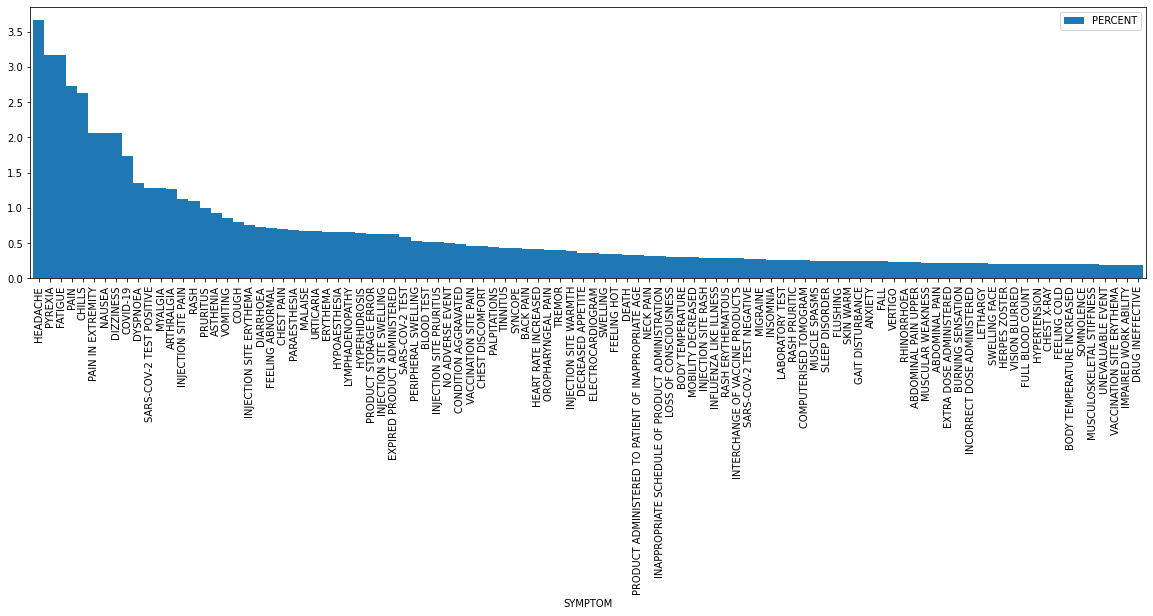

In [18]:

# lets put it in a barchart!
df_symptoms.head(topX).plot.bar(x='SYMPTOM',y='PERCENT',rot=90,figsize=(20,5),width=1)


## break down functions...
these functions will help me breakdown the data

### break_down_columns

In [19]:

def break_down_columns(idf,column):
    """
    shows what values there are for a given column (with counts and percent)
    """
    print('\nbreak down of {0}'.format(column))
    idf = pd.DataFrame(idf[column])
    idf = idf.fillna('nan')

    result = []

    l = list(idf[column].unique())
    for i in l:
        df0 = idf[idf[column]==i]
        result.append({'column':column,'value':i,'count':len(df0),'percent':(len(df0)/len(idf))*100})
    
    result = pd.DataFrame(result)
    display(result)
    return result

# test
# break_down_columns(df,'DIED')



### break_down_buckets

In [20]:


def break_down_buckets(idf,column,buckets,message='',nan_value=-1):
    """
    breaks a column down into buckets/bins
    """
    idf = idf.fillna(nan_value)

    print('',message,'\ncolumn: ',column, '\nbuckets: ', buckets)
    
    idf = pd.DataFrame(idf[column])
    idf['bucket'] = pd.cut(idf[column], bins=buckets)
    idf = idf.groupby(by='bucket').count()
    idf['percent'] = (idf[column]/idf[column].sum())*100
    idf['percent'] = idf['percent'].round(2)
    display(idf)

    return idf

#test
# break_down_buckets(df,'AGE_YRS',[-1,0,15,25,35,45,55,65,75,85,500])


## Additional Numbers

these numbers are **not** part of the vaers data,  
however they are important to analyzing the data

vaxx (int) : ~~the number of vaccinated (1 or more shots) US citizens according to a quick google search (on 8/3/2021)~~

**google no longer shows partially vaxxed**  so we are using the **Total doses given** number  
"Total doses given" shows the number of vaccine doses given to people. Since some vaccines require more than 1 dose, the number of fully vaccinated people is likely lower. "People fully vaccinated" shows how many people have received the full amount of doses for the COVID-19 vaccine.  

this number was updated on 06/28/2022

full_vaxx (int) : the number of vaccinated (2 or more shots) US citizens according to a quick google search (on 06/28/2022)


In [21]:
vaxx = 594*10**6
full_vaxx = 222*10**6

In [39]:
#only death vaers
df_death = df[df['DIED']=='Y']

## Analyzing the df (all_data.json)
this is just a generic break down of the data

df_death (DataFrame) :  adverse reactions that resulted in a death

### DIED column


break down of DIED


,column,value,count,percent
0,DIED,nan,861350,98.181362
1,DIED,Y,15955,1.818638



-------------------------



<AxesSubplot:title={'center':'DIED'}, ylabel='percent'>

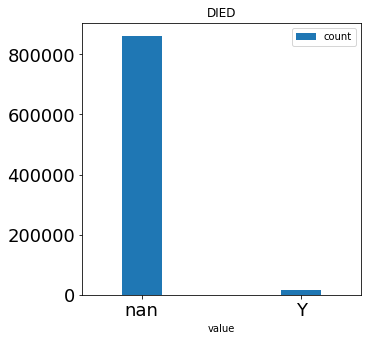

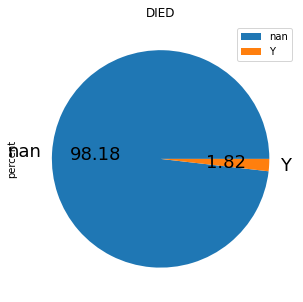

In [41]:

temp = break_down_columns(df,'DIED')
print('\n' + '-'*25 + '\n')


temp.plot.bar(title='DIED',x='value',y='count',rot=0,figsize=(5,5),width=0.25,fontsize=18)
temp = temp.set_index('value')
temp.plot.pie(title='DIED',y='percent',figsize=(5, 5),autopct='%.2f',fontsize=18)


### ER_VISIT column

did the adverse reaction result in an ER Visit

break down of ER_VISIT


,column,value,count,percent
0,ER_VISIT,nan,877182,99.98598
1,ER_VISIT,Y,123,0.01402



-------------------------



<AxesSubplot:title={'center':'ER_VISIT'}, ylabel='percent'>

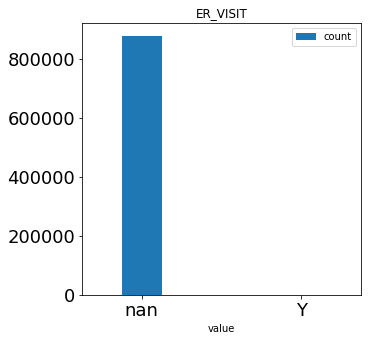

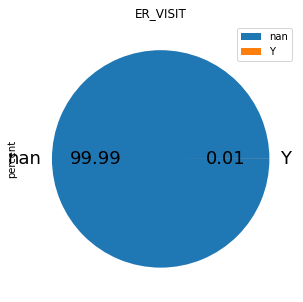

In [42]:

print('did the adverse reaction result in an ER Visit')
temp = break_down_columns(df,'ER_VISIT')
print('\n' + '-'*25 + '\n')

temp.plot.bar(title='ER_VISIT',x='value',y='count',rot=0,figsize=(5,5),width=0.25,fontsize=18)
temp = temp.set_index('value')
temp.plot.pie(title='ER_VISIT',y='percent',figsize=(5, 5),autopct='%.2f',fontsize=18)

### L_THREAT column

Life Threatening/Leathal Threat

break down of L_THREAT


,column,value,count,percent
0,L_THREAT,nan,863004,98.369894
1,L_THREAT,Y,14301,1.630106



-------------------------



<AxesSubplot:title={'center':'L_THREAT'}, ylabel='percent'>

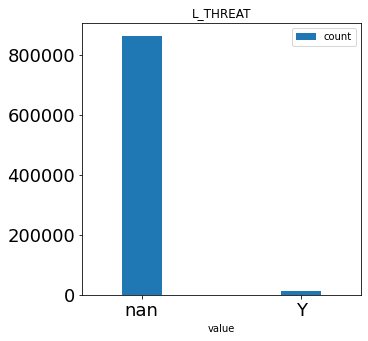

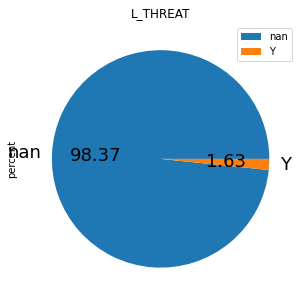

In [43]:

print('Life Threatening/Leathal Threat')
temp = break_down_columns(df,'L_THREAT')
print('\n' + '-'*25 + '\n')

temp.plot.bar(title='L_THREAT',x='value',y='count',rot=0,figsize=(5,5),width=0.25,fontsize=18)
temp = temp.set_index('value')
temp.plot.pie(title='L_THREAT',y='percent',figsize=(5, 5),autopct='%.2f',fontsize=18)

### RECOVD column

did the patient recover?

break down of RECOVD


,column,value,count,percent
0,RECOVD,Y,267282,30.466257
1,RECOVD,N,300511,34.253880
2,RECOVD,U,205479,23.421615
3,RECOVD,nan,104033,11.858248



-------------------------



<AxesSubplot:title={'center':'RECOVD'}, ylabel='percent'>

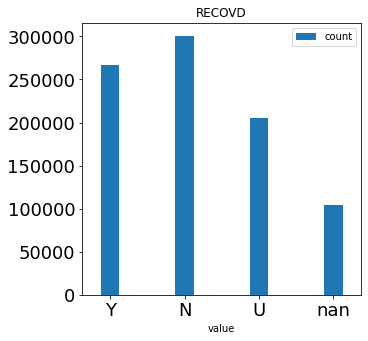

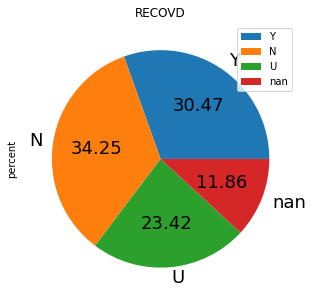

In [44]:

print('did the patient recover?')
temp = break_down_columns(df,'RECOVD')

print('\n' + '-'*25 + '\n')

temp.plot.bar(title='RECOVD',x='value',y='count',rot=0,figsize=(5,5),width=0.25,fontsize=18)
temp = temp.set_index('value')
temp.plot.pie(title='RECOVD',y='percent',figsize=(5, 5),autopct='%.2f',fontsize=18)

### the Age of the patient

the Age of the patient
  
column:  AGE_YRS 
buckets:  [0, 15, 25, 35, 45, 55, 65, 75, 85, 500]


,AGE_YRS,percent
bucket,,
"(0, 15]",29933,3.78
"(15, 25]",67964,8.58
"(25, 35]",109769,13.86
"(35, 45]",127400,16.08
"(45, 55]",128980,16.28
"(55, 65]",136893,17.28
"(65, 75]",116454,14.70
"(75, 85]",55471,7.00
"(85, 500]",19358,2.44



-------------------------

 ***deaths only*** 
column:  AGE_YRS 
buckets:  [0, 15, 25, 35, 45, 55, 65, 75, 85, 500]


,AGE_YRS,percent
bucket,,
"(0, 15]",34,0.23
"(15, 25]",124,0.85
"(25, 35]",215,1.47
"(35, 45]",405,2.77
"(45, 55]",811,5.55
"(55, 65]",2139,14.63
"(65, 75]",3671,25.10
"(75, 85]",4129,28.23
"(85, 500]",3096,21.17



-------------------------



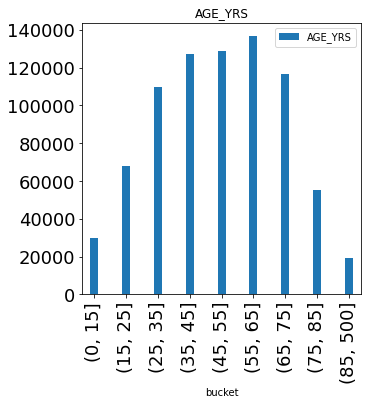

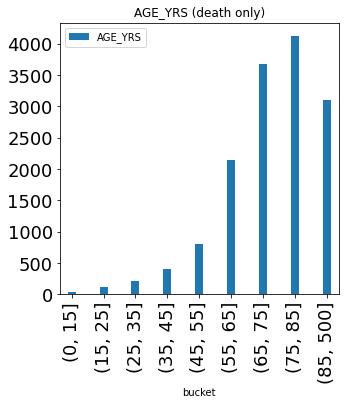

In [45]:


print('the Age of the patient')
temp = break_down_buckets(df,'AGE_YRS',[0,15,25,35,45,55,65,75,85,500])

temp = temp.reset_index()
temp.plot.bar(title='AGE_YRS',x='bucket',y='AGE_YRS',rot=90,figsize=(5,5),width=0.25,fontsize=18)
# temp.plot.bar(title='AGE_YRS',x='bucket',y='percent',rot=90,figsize=(5,5),width=0.25,fontsize=18)

print('\n' + '-'*25 + '\n')

temp = break_down_buckets(df_death,'AGE_YRS',[0,15,25,35,45,55,65,75,85,500],message='***deaths only***')

temp = temp.reset_index()
temp.plot.bar(title='AGE_YRS (death only)',x='bucket',y='AGE_YRS',rot=90,figsize=(5,5),width=0.25,fontsize=18)
# temp.plot.bar(title='AGE_YRS (death only)',x='bucket',y='percent',rot=90,figsize=(5,5),width=0.25,fontsize=18)

print('\n' + '-'*25 + '\n')




### the number of days between the vaccine and the adverse rection

the number of days between the vaccine and the adverse rection
  
column:  NUMDAYS 
buckets:  [0, 10, 20, 30, 40, 50, 60]


,NUMDAYS,percent
bucket,,
"(0, 10]",279931,76.34
"(10, 20]",36386,9.92
"(20, 30]",26638,7.26
"(30, 40]",12666,3.45
"(40, 50]",6204,1.69
"(50, 60]",4846,1.32



-------------------------

 ***deaths only*** 
column:  NUMDAYS 
buckets:  [0, 10, 20, 30, 40, 50, 60]


,NUMDAYS,percent
bucket,,
"(0, 10]",3582,53.59
"(10, 20]",1158,17.32
"(20, 30]",815,12.19
"(30, 40]",484,7.24
"(40, 50]",338,5.06
"(50, 60]",307,4.59



-------------------------



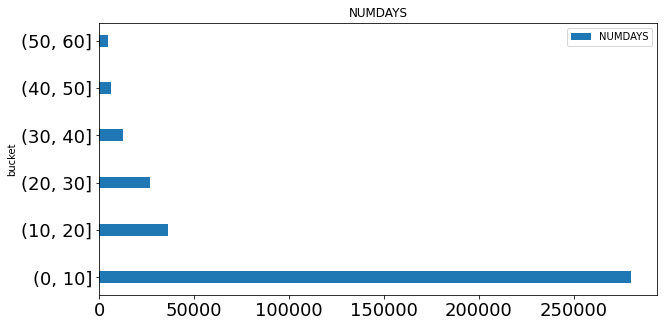

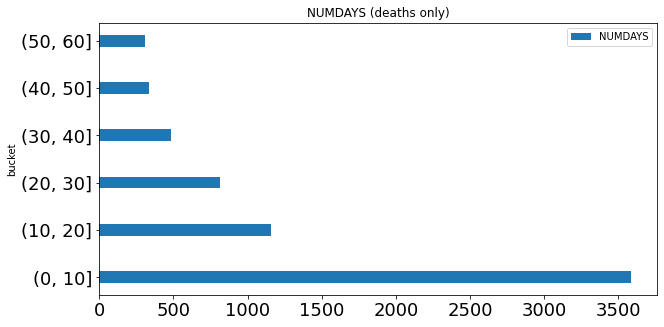

In [46]:


print('the number of days between the vaccine and the adverse rection')
temp = break_down_buckets(df,'NUMDAYS',[0,10,20,30,40,50,60])

temp = temp.reset_index()
temp.plot.barh(title='NUMDAYS',x='bucket',y='NUMDAYS',rot=0,figsize=(10,5),width=0.25,fontsize=18)
# temp.plot.bar(title='AGE_YRS',x='bucket',y='percent',rot=90,figsize=(5,5),width=0.25,fontsize=18)

print('\n' + '-'*25 + '\n')

temp = break_down_buckets(df_death,'NUMDAYS',[0,10,20,30,40,50,60],message='***deaths only***')

temp = temp.reset_index()
temp.plot.barh(title='NUMDAYS (deaths only)',x='bucket',y='NUMDAYS',rot=0,figsize=(10,5),width=0.25,fontsize=18)
# temp.plot.bar(title='AGE_YRS',x='bucket',y='percent',rot=90,figsize=(5,5),width=0.25,fontsize=18)

print('\n' + '-'*25 + '\n')


### break down of the VAX_NAME column

break down of the VAX_NAME column

break down of VAX_NAME


,column,value,count,percent
0,VAX_NAME,COVID19 (COVID19 (PFIZER-BIONTECH)),407488,46.447701
1,VAX_NAME,COVID19 (COVID19 (UNKNOWN)),2789,0.317905
2,VAX_NAME,COVID19 (COVID19 (MODERNA)),397378,45.295308
3,VAX_NAME,COVID19 (COVID19 (JANSSEN)),69650,7.939086



***deaths only***

break down of VAX_NAME


,column,value,count,percent
0,VAX_NAME,COVID19 (COVID19 (MODERNA)),6628,41.541836
1,VAX_NAME,COVID19 (COVID19 (PFIZER-BIONTECH)),7631,47.828267
2,VAX_NAME,COVID19 (COVID19 (UNKNOWN)),54,0.338452
3,VAX_NAME,COVID19 (COVID19 (JANSSEN)),1642,10.291445


calculating the death ratio ( death_count / count )


,column,value,count,death_count,death_ratio,death_percent
0,VAX_NAME,COVID19 (COVID19 (PFIZER-BIONTECH)),407488,7631,0.018727,1.872693
1,VAX_NAME,COVID19 (COVID19 (UNKNOWN)),2789,54,0.019362,1.936178
2,VAX_NAME,COVID19 (COVID19 (MODERNA)),397378,6628,0.016679,1.667933
3,VAX_NAME,COVID19 (COVID19 (JANSSEN)),69650,1642,0.023575,2.357502



-------------------------



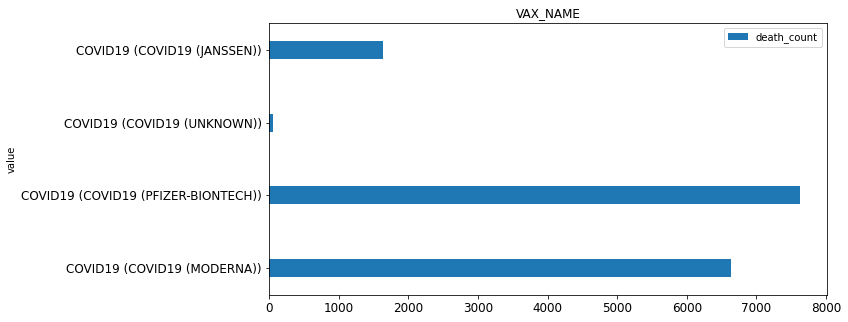

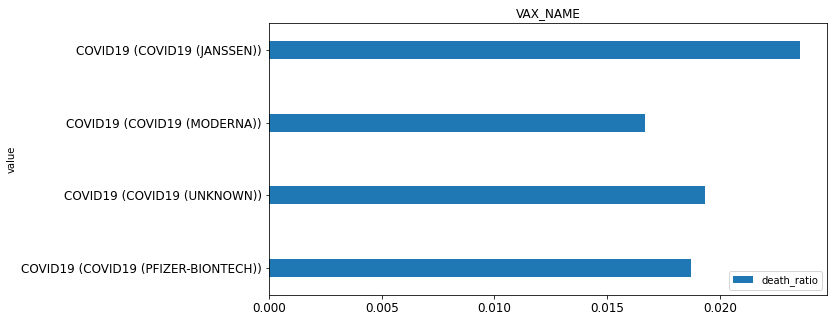

In [47]:

print('break down of the VAX_NAME column')
df_VN = break_down_columns(df,'VAX_NAME')

print('\n***deaths only***')
df_DVN = break_down_columns(df_death,'VAX_NAME')

# df_CVN = df_VN.join(df_DVN[['value','count']],on='value')
df_DVN = df_DVN.rename(columns={"count": "death_count"})


print('calculating the death ratio ( death_count / count )')
df_CVN = pd.concat([df_VN,df_DVN],keys=['value'],join="inner",axis=1)

df_CVN = pd.merge(df_VN,df_DVN,on=['value'])
df_CVN = df_CVN.drop(columns=['percent_x','percent_y','column_y']) 
df_CVN = df_CVN.rename(columns={"column_x": "column"})
df_CVN['death_ratio'] = df_CVN['death_count'] / df_CVN['count']
df_CVN['death_percent'] = df_CVN['death_ratio']*100

display(df_CVN)


temp = df_DVN
temp.plot.barh(title='VAX_NAME',x='value',y='death_count',rot=0,figsize=(10,5),width=0.25,fontsize=12)

temp = df_CVN
temp.plot.barh(title='VAX_NAME',x='value',y='death_ratio',rot=0,figsize=(10,5),width=0.25,fontsize=12)

print('\n' + '-'*25 + '\n')

## Approximating actual adverse reaction numbers

VAERS only contains reported data and  
*'...fewer than 1% of vaccine adverse events are reported.'*  
Source: 
https://digital.ahrq.gov/sites/default/files/docs/publication/r18hs017045-lazarus-final-report-2011.pdf (page 6)


we will me multiplying the counts by 80 and 120,  
in order to get an approzimate min and max of what the numbers might actually be.  



In [48]:

def print_percent(vmin,vmax,label0,vcount,label1):
    """
    vmin: vaers min
    vmax: vaers max
    label0: vaers label
    vcount: vaxxed count
    label1: vaxxed label
    """
    print(
        '( {label0} / {lavel1} ) * 100\n'.format(
            label0=label0,
            lavel1=label1
            ),
        'min: ( {0:,} / {1:,} ) * 100 \n'.format(vmin,vcount),
        'max: ( {0:,} / {1:,} ) * 100 \n'.format(vmax,vcount),
        '{:.2f} %'.format((vmin/vcount)*100),
        '-',
        '{:.2f} %'.format((vmax/vcount)*100),
        '\n'
        )   

print_percent(
    len(df)*80,
    len(df)*120,
    'approx adverse reactions',
    vaxx,
    'vaxxed [1 or more shots]'
    )

print_percent(
    len(df_death)*80,
    len(df_death)*120,
    'approx adverse deaths',
    vaxx,
    'vaxxed [1 or more shots]'
    )

df_nrecovd = df[df['RECOVD']=='N']
print_percent(
    len(df_nrecovd)*80,
    len(df_nrecovd)*120,
    'approx no recovery',
    vaxx,
    'vaxxed [1 or more shots]'
    )

df_urecovd = df[df['RECOVD']=='U']
print_percent(
    (len(df_nrecovd) + (len(df_urecovd)*0.5))*80,
    (len(df_nrecovd) + (len(df_urecovd)*0.5))*120,
    'approx no recovery + (50% of unknowns)',
    vaxx,
    'vaxxed [1 or more shots]'
    )


( approx adverse reactions / vaxxed [1 or more shots] ) * 100
 min: ( 70,184,400 / 241,000,000 ) * 100 
 max: ( 105,276,600 / 241,000,000 ) * 100 
 29.12 % - 43.68 % 

( approx adverse deaths / vaxxed [1 or more shots] ) * 100
 min: ( 1,276,400 / 241,000,000 ) * 100 
 max: ( 1,914,600 / 241,000,000 ) * 100 
 0.53 % - 0.79 % 

( approx no recovery / vaxxed [1 or more shots] ) * 100
 min: ( 24,040,880 / 241,000,000 ) * 100 
 max: ( 36,061,320 / 241,000,000 ) * 100 
 9.98 % - 14.96 % 

( approx no recovery + (50% of unknowns) / vaxxed [1 or more shots] ) * 100
 min: ( 32,260,040.0 / 241,000,000 ) * 100 
 max: ( 48,390,060.0 / 241,000,000 ) * 100 
 13.39 % - 20.08 % 



## Women's Reproductive Symptoms

Why?
I have women in my life that were curious about this.

WRS_list (list) :  a list of symptoms that effect or could cause effects to a women's reproductive system  
df_WRS (DataFrame) :  a dataframe that contains VAERS events that have at least 1 of the WRS symptoms

In [50]:
def symptom_filter_search(idf, search_list):
    """
    returns a dataframe pf vaers events where the patient 
    has had 1 or more of the symptoms on the list
    """
    print('this could take between 20sec-60sec')

    data = idf.to_dict(orient='records')

    search_list = [i.upper() for i in search_list]
    
    results = []
    for index,d in enumerate(data):
        # if index%5000 == 0:
        #     print('{:.2f}'.format(index/len(data)))
        try:
            d['SYMPTOMS'] = [i.upper() for i in d['SYMPTOMS'] if isinstance(i, str)]
        
            symptom_match = list(set(d['SYMPTOMS']) & set(search_list))
            d['SYMPTOMS_MATCH'] = symptom_match
            d['SYMPTOMS_MATCH_LENGTH'] = len(symptom_match)
            if len(symptom_match) > 0:
                results.append(d)
        except:
            pass

    return pd.DataFrame(results)

In [52]:
WRS_list = [
    'Intermenstrual bleeding',
    'Menopause',
    'Heavy menstrual bleeding',
    'dysmenorrhoea',
    'ABNORMAL UTERINE BLEEDING',
    'MATERNAL EXPOSURE BEFORE PREGNANCY',
    'MENSTRUATION IRREGULAR',
    'Oligomenorrhea',
    'OLIGOMENORRHOEA',
    'POLYMENORRHOEA',
    'MENSTRUAL DISORDER', 
    'OLIGOMENORRHOEA',
    'ANOVULATORY CYCLE',
    'OVULATION DELAYED',
    'BACTERIAL VAGINOSIS',
    'GYNAECOLOGICAL EXAMINATION ABNORMAL',
    'OVARIAN CYST',
    'BIOPSY UTERUS',
    'UTERINE LEIOMYOMA',
    'HOT FLUSH',
    'BREAST TENDERNESS',
    'BREAST SWELLING',
    'BREAST PAIN',
    'VAGINAL HAEMORRHAGE'
    ]
WRS_list = [i.upper() for i in WRS_list]

In [53]:
df_WRS = symptom_filter_search(df,WRS_list)

print('df_WRS.head(5)')
display(df_WRS.head(5))


this could take between 20sec-60sec


KeyboardInterrupt: 

### What percent of women experienced WRS during their adverse reactions?

(women experiencing reproductive symptoms ➗ number of women in VAERS data) * 100

WRS_ratio (float) : count WRS / count VAERS

In [ ]:
#get count of women in VAERS data 

w_df = df[df['SEX']=='F']
u_df = df[df['SEX']=='U']
w_count = len(w_df) + (len(u_df)/2) #half of unknown

WRS_ratio = (len(df_WRS)/w_count)

print( '{:.2f} %'.format(WRS_ratio*100))

file_name = os.path.join(DATAPATH,'WRS.csv')
df_WRS.to_csv(file_name)

print('VAERS records of women experiencing reproductive symptoms have been saved.')
print('saved: ',file_name)



3.53 %
VAERS records of women experiencing reproductive symptoms have been saved.
saved:  .\AllVAERSDataCSVS\WRS.csv


### Approximate the number of WRS in reality

since '~63% of the people who are vaccinated are women'
source: https://www.statista.com/statistics/1212103/share-of-persons-initiating-covid-vaccinations-by-gender-us-first-month/

we will be multiplying the total number of people vaccinated (1 or more shots) by 0.63 to get the count of women vaccinated.

women_vaxx (float) : an approximate number of women who have had 1 or more vaccine shot.

>note: 0.63 is an estimate, and the actual could be somewhere between 0.50 and 0.70

In [ ]:
women_vaxx = vaxx * 0.63
print(women_vaxx)

151830000.0


### approximate real WRS
if we assume that the VAERS data is a random sample (or close to it)  
then the ratio of WRS systems should be the same...

and thus we can get an approximate number of women that would be experiencing reproductive symptoms by multiplying the number of vaxxed women by the ratio

WRS (float) : the approximate number of actual women experiencing reproductive symptoms
min_WRS (float) : WRS * 0.80
max_WRS (float) : WRS * 1.20

In [54]:
WRS = women_vaxx * WRS_ratio
min_WRS = WRS*0.80
max_WRS = WRS*1.20

In [55]:
cl = [35,5,15]
print_row(['total vaxxed (1 or more)','---','{:,.2f}'.format(vaxx)],column_lengths=cl)
print_row(['women vaxxed ~0.63%','---','{:,.2f}'.format(women_vaxx)],column_lengths=cl)
print_row(['repro sympt / women count','---','{:,.4f}'.format(WRS_ratio)],column_lengths=cl)
print_row(['(repro sympt / women count) * 100','---','{:,.2f} %'.format(WRS_ratio*100)],column_lengths=cl)
print_row(['women w/ repro symptoms','---','{:,.2f}'.format(WRS)],column_lengths=cl)
print_row(['min women w/ repro symptoms','---','{:,.2f}'.format(min_WRS)],column_lengths=cl)
print_row(['max women w/ repro symptoms','---','{:,.2f}'.format(max_WRS)],column_lengths=cl)


total vaxxed (1 or more)           ---  241,000,000.00 
women vaxxed ~0.63%                ---  151,830,000.00 
repro sympt / women count          ---  0.0353         
(repro sympt / women count) * 100  ---  3.53 %         
women w/ repro symptoms            ---  5,356,533.32   
min women w/ repro symptoms        ---  4,285,226.65   
max women w/ repro symptoms        ---  6,427,839.98   


### Where do the WRS (Women reproductive symptoms) rank against with the other symptoms?

In [56]:
temp = []

for index,i in enumerate(all_symptoms):
    if i[0].upper() in WRS_list:
        temp.append(
            {
                'index':index,
                'symptoms':i[0],
                'count': '{:,.2f}'.format(i[1]),
                'percent': '{:.2f}'.format((i[1]/len(all_symptoms))*100) 
            }
        )

temp = pd.DataFrame(temp)
display(temp)

,index,symptoms,count,percent
0,125,HEAVY MENSTRUAL BLEEDING,"5,527.00",47.18
1,164,MENSTRUATION IRREGULAR,"4,218.00",36.01
2,166,HOT FLUSH,"4,137.00",35.32
3,191,MENSTRUAL DISORDER,"3,160.00",26.98
4,233,DYSMENORRHOEA,"2,331.00",19.90
5,242,BREAST PAIN,"2,238.00",19.11
6,268,VAGINAL HAEMORRHAGE,"1,914.00",16.34
7,291,INTERMENSTRUAL BLEEDING,"1,637.00",13.97
8,458,BREAST SWELLING,870.00,7.43
9,472,POLYMENORRHOEA,840.00,7.17
